# ei_selection.ipynb
This notebook is used to create a balanced network of excitatory and inhibitory units that become selective
for particular input patterns. It has the same network as ei_selective.ipynb, but in here most things are 
encapsulated within the selection class.

By Sergio Verduzco Flores        August 2017

The cells below:
* Create two NxN layers, one excitatory, and one inhibitory.
* Connect the layers with center-excitation surround-inhibition connectivity. E-E connections use
  Hebbian learning with substractive normalization, I-E connections use homeostatic inhibition,
  similar to Moldakarimov06 (in ei_net.ipynb).
* Create an input layer where the activity of each unit is a function of the current input pattern.
* Connects the input layer to E,I layers using a connection pattern based on a Gaussian kernel, and
  using BCM synapses.
* Runs a simulation where input patterns are randomly selected and presented sequentially, similarly
  to the way this was done in the test3,4,5 notebooks.
  
The experiment consists of finding whether selectivity to patterns will arise in the units.
- - -


In [1]:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

/home/z/projects/draculab


In [2]:
class parameters():
    """
        Instances of this class contain all the parameters used by the 'selection' class.
        
        All parameters derived from other parameters will be recalculated in 
        selection.__init__ . They're here too for readability.
    """
    def __init__(self):
        ########################## Here be all parameters
        # NETWORK PARAMETERS 
        self.md = 0.1 # minimum delay in the network
        self.min_buff_size = 5 # minimum buffer size
        self.rtol = 1e-4 # relative tolerance of the ODE solver
        self.atol = 1e-4 # absolute tolerance of the ODE solver
        self.N = 5 # The network's layers will have size NxN
        N = self.N # for brevity
        self.L = N/2. + 2./N # side length of rectangle with the square grids.
        L = self.L
        
        # EXCITATORY UNIT PARAMETERS
        self.exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        self.exc_init_val = np.random.uniform(0.1, 0.6, N*N)  # initial activations (around IE_des_act)
        self.exc_tau_fast = 0.2  # time constant of the fast low-pass filter
        self.exc_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        self.fe_thr = 0.3 # threshold of the f-I curve
        self.fe_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the excitatory units
        self.exc_shape = 'sheet'
        self.exc_extent = [L, L]
        self.exc_arrangement = 'grid'
        self.exc_rows = N
        self.exc_columns = N
        self.exc_center = [0., 0.]
        
        # INHIBITORY UNIT PARAMETERS
        self.inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        self.inh_init_val = np.random.uniform(0.1, 0.6, N*N)  # initial activations
        self.inh_tau_fast = 0.2  # time constant of the fast low-pass filter
        self.inh_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        self.fi_thr = 0.4 # threshold of the f-I curve
        self.fi_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the inhibitory units
        self.inh_shape = 'sheet'
        self.inh_extent = [L, L]
        self.inh_arrangement = 'grid'
        self.inh_rows = N
        self.inh_columns = N
        self.inh_center = [0., 0.]
        
        # INPUT UNIT PARAMETERS
        self.inp_init_val = 0.2 # initial activation
        self.inp_tau_fast = 0.2 # time constant of the fast low-pass filter
        # geometrical arrangement of the input units
        self.inp_shape = 'sheet'
        self.inp_extent = [L, L]
        self.inp_arrangement = 'grid'
        self.inp_rows = N
        self.inp_columns = N
        self.inp_center = [0., 0.]
        
        # E-I CONNECTIONS
        self.EI_connection_type = 'convergent'
        self.EI_mask = {'annular':{'inner_radius' : 1.1, 'outer_radius':4.1}}
        self.EI_kernel = {'linear' : {'c' : 1., 'a' : 0.2}}
        self.EI_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.EI_weights = {'uniform' : {'low' : 0.5, 'high' : 0.8}}
        self.EI_edge_wrap = True
        self.EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.EI_type = synapse_types.static
        
        # E-E CONNECTIONS
        self.EE_connection_type = 'divergent'
        self.EE_mask = {'circular':{'radius':2.}}
        self.EE_kernel = {'gaussian' : {'p_center' : 1., 'sigma' : 1.}}
        self.EE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.EE_weights =  {'uniform' : {'low' : 0.1, 'high' : 0.6}}
        self.EE_edge_wrap = True
        self.EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.EE_type = synapse_types.sq_hebbsnorm 
        self.EE_lrate = 1./200. # learning rate
        self.EE_omega = 2.5  # sum of squared EE weights 
        
        # I-E CONNECTIONS
        self.IE_connection_type = 'divergent'
        self.IE_mask = {'circular':{'radius':2.}}
        self.IE_kernel = {'gaussian' : {'p_center' : 1.4, 'sigma' : 1.}}
        self.IE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.IE_weights =  {'uniform' : {'low' : -0.6, 'high' : -0.1}}
        self.IE_edge_wrap = True
        self.IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.IE_type = synapse_types.homeo_inh
        self.IE_lrate = 1./100. 
        self.IE_des_act = 0.3
        
        # INP_EXC CONNECTIONS
        self.PE_connection_type = 'divergent'
        self.PE_mask = {'circular':{'radius':3.5}}
        self.PE_kernel = 0.6
        self.PE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.PE_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        self.PE_edge_wrap = True
        self.PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.PE_type = synapse_types.bcm
        self.PE_lrate = 1./200.
        
        # INP_INH CONNECTIONS
        self.PI_connection_type = 'divergent'
        self.PI_mask = {'circular':{'radius':3.5}}
        self.PI_kernel = 0.6
        self.PI_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.PI_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        self.PI_edge_wrap = True
        self.PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.PI_type = synapse_types.bcm
        self.PI_lrate = 1./200.
        
        # PATTERN PRESENTATION
        self.t_pat = 20. # time each pattern will be presented
        self.t_trans = 5. # length of transition period between patterns
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
        self.pat_type = 'lines' # see selection.build()
        

In [3]:
class selection():
    def __init__(self, p):
        """ Initialize parameter dictionaries using the parameter object p. """
        # optionally, seed the random number generator
        #np.random.seed(54321)
        
        ########################## Initialize derived parameters
        N = p.N; # N is used often. Might as well make a local copy.
        p.L = N/2. + 2./N # side length of the square unit grids   
        L = p.L
        p.exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        p.exc_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        p.exc_extent = [L, L]
        p.exc_rows = N
        p.exc_columns = N
        p.inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        p.inh_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        p.inh_extent = [L, L]
        p.inh_rows = N
        p.inh_columns = N
        p.inp_extent = [L, L]
        p.inp_rows = N
        p.inp_columns = N
        p.EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.EI_delays['linear']['c'] = p.md
        p.EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.EE_delays['linear']['c'] = p.md
        p.IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.IE_delays['linear']['c'] = p.md
        p.PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.PE_delays['linear']['c'] = p.md
        p.PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.PI_delays['linear']['c'] = p.md
        # stuff used to create input functions
        self.t_trans = p.t_trans
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
        self.t_pat = p.t_pat
        self.params = p
        
        ########################## Initialize all the parameter dictionaries 
        self.net_params = {'min_delay' : p.md, 
                           'min_buff_size' : p.min_buff_size, 
                           'rtol':p.rtol, 
                           'atol':p.atol } 
        self.exc_params = {'tau' : p.exc_tau,
                           'function' : self.make_fe(p.fe_thr, p.fe_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : p.exc_init_val, 
                           'tau_fast' : p.exc_tau_fast, 
                           'tau_slow' : p.exc_tau_slow } # tau_slow vs lrate controls stability of BCM
        self.exc_geom = {'shape' : p.exc_shape, 
                         'extent' : p.exc_extent, 
                         'arrangement' : p.exc_arrangement, 
                         'rows' : p.exc_rows, 
                         'columns' : p.exc_columns, 
                         'center' : p.exc_center }
        self.inh_params = {'tau' :p.inh_tau, 
                           'function' : self.make_fi(p.fi_thr, p.fi_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : p.inh_init_val, 
                           'tau_fast' : p.inh_tau_fast, 
                           'tau_slow' : p.inh_tau_slow }
        self.inh_geom = {'shape' : p.inh_shape, 
                         'extent' : p.inh_extent, 
                         'arrangement' : p.inh_arrangement, 
                         'rows' : p.inh_rows, 
                         'columns' : p.inh_columns, 
                         'center' : p.inh_center }
        self.inp_params = {'type' : unit_types.source, 
                           'init_val' : p.inp_init_val, 
                           'tau_fast' : p.inp_tau_fast, 
                           'function' : lambda x: None }
        self.inp_geom = {'shape' : p.inp_shape, 
                         'extent' : p.inp_extent, 
                         'arrangement' : p.inp_arrangement, 
                         'rows' : p.inp_rows, 
                         'columns' : p.inp_columns, 
                         'center' : p.inp_center }
        self.EI_conn = {'connection_type' : p.EI_connection_type,
                        'mask' : p.EI_mask,
                        'kernel' : p.EI_kernel,
                        'delays' : p.EI_delays,
                        'weights' : p.EI_weights,
                        'edge_wrap' : p.EI_edge_wrap,
                        'boundary' : p.EI_boundary }
        self.EI_syn = {'type' : p.EI_type }
        self.EE_conn = {'connection_type' : p.EE_connection_type,
                        'mask' : p.EE_mask,
                        'kernel' : p.EE_kernel,
                        'delays' : p.EE_delays,
                        'weights' : p.EE_weights,
                        'edge_wrap' : p.EE_edge_wrap,
                        'boundary' : p.EE_boundary }
        self.EE_syn = {'type' : p.EE_type, 
                       'lrate' : p.EE_lrate, 
                       'omega' : p.EE_omega } 
        self.IE_conn = {'connection_type' : p.IE_connection_type,
                        'mask' : p.IE_mask,
                        'kernel' : p.IE_kernel,
                        'delays' : p.IE_delays,
                        'weights' : p.IE_weights,
                        'edge_wrap' : p.IE_edge_wrap,
                        'boundary' : p.IE_boundary }
        self.IE_syn = {'type' : p.IE_type, 
                       'lrate' : p.IE_lrate, 
                       'des_act' : p.IE_des_act }
        self.PE_conn = {'connection_type' : p.PE_connection_type,
                        'mask' : p.PE_mask,
                        'kernel' : p.PE_kernel,
                        'delays' : p.PE_delays,
                        'weights' : p.PE_weights,
                        'edge_wrap' : p.PE_edge_wrap,
                        'boundary' : p.PE_boundary }
        self.PE_syn = {'lrate' : p.PE_lrate, 
                       'type' : p.PE_type }
        self.PI_conn = {'connection_type' : p.PI_connection_type,
                        'mask' : p.PI_mask,
                        'kernel' : p.PI_kernel,
                        'delays' : p.PI_delays,
                        'weights' : p.PI_weights,
                        'edge_wrap' : p.PI_edge_wrap,
                        'boundary' : p.PI_boundary }
        self.PI_syn = {'lrate' : p.PI_lrate, 
                       'type' : p.PI_type }
        
    def build(self):            
        topo = topology() # the topology class. Used to create spatially patterned connections
        #build network
        self.net = network(self.net_params)
        # build units
        self.exc = topo.create_group(self.net, self.exc_geom, self.exc_params)
        self.inh = topo.create_group(self.net, self.inh_geom, self.inh_params)
        self.inp = topo.create_group(self.net, self.inp_geom, self.inp_params)
        # build connections
        topo.topo_connect(self.net, self.exc, self.inh, self.EI_conn, self.EI_syn)
        topo.topo_connect(self.net, self.exc, self.exc, self.EE_conn, self.EE_syn)
        topo.topo_connect(self.net, self.inh, self.exc, self.IE_conn, self.IE_syn)
        topo.topo_connect(self.net, self.inp, self.exc, self.PE_conn, self.PE_syn)
        topo.topo_connect(self.net, self.inp, self.inh, self.PI_conn, self.PI_syn)
        
        # create the input patterns
        N = self.inp_geom['rows'] # number of patterns based on input layer size
        if self.params.pat_type == 'random':
            n_pat = int(round(1.5*N))  # number of different patterns
            n_ones = int(round(N*N)/3) # number of ones in the input patterns
            basic_pat = np.array( [1.]*n_ones + [0.]*(N*N - n_ones) )
            basic_pat = basic_pat/np.sqrt(sum(basic_pat)) # normalizing
            self.patterns = [basic_pat.copy() for i in range(n_pat)]
            for pat in self.patterns:
                np.random.shuffle(pat)
        elif self.params.pat_type == 'snake': # intersecting lines
            n_pat = int(round(1.5*N))  # number of different patterns
            length = int(round(N*N/3.))
            advance = int(round(N*N/n_pat))
            base = np.zeros(N*N)
            base[0:length] = np.ones(length)/np.sqrt(length)
            self.patterns = [np.zeros(N*N) for _ in range(n_pat)]
            for pat in range(n_pat):
                self.patterns[pat] = np.roll(base, pat*advance)
        elif self.params.pat_type == 'lines': # separate lines
            n_pat = N  # number of different patterns
            self.patterns = [np.zeros((N,N)) for _ in range(n_pat)]
            for num,pat in enumerate(self.patterns):
                if num < N:
                    pat[:,num] = np.ones(N)
                    self.patterns[num] = pat.reshape(N*N, order='F') 
                    # the conversion from shape N*N to shape (N,N) must follow the index-location
                    # relation created by create_group using grid arrangement
        
        # print average number of connections of each type
        sum_ee = 0 # number of e-e connections
        sum_ei = 0
        sum_ie = 0
        sum_pe = 0 # number of input to exc connections
        sum_pi = 0
        for syn_list in self.net.syns:
            for syn in syn_list:
                if syn.postID in self.exc:
                    if syn.preID in self.exc:
                        sum_ee += 1
                    elif syn.preID in self.inh:
                        sum_ie += 1
                    else:
                        sum_pe += 1
                elif syn.postID in self.inh:
                    if syn.preID in self.exc:
                        sum_ei += 1
                    else:
                        sum_pi += 1
        Nsq = self.params.N * self.params.N
        print("Average number of incoming EE connections: %f" % (sum_ee/Nsq))
        print("Average number of incoming EI connections: %f" % (sum_ei/Nsq))
        print("Average number of incoming IE connections: %f" % (sum_ie/Nsq))
        print("Average number of incoming PE connections: %f" % (sum_pe/Nsq))
        print("Average number of incoming PI connections: %f" % (sum_pi/Nsq))
        
    def make_fe(self, th, eps): # returns a function as in Eq. 1 of the paper
        return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
    
    def make_fi(self, th, eps): # returns a function as in Eq. 2 of the paper
        return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
    
    def make_pulse(self, t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
        return lambda t : 1. if (t_init < t and t < t_end) else 0.
    
    def make_sin_pulse(self, t_init, t_end, per): # the stimulus used in Moldakarimov et al.
        return lambda t : 1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) if (t_init < t and t < t_end) else 0.
    
    def plot_stuff(self, data): 
        N = self.params.N
        fig = plt.figure(figsize=(8,8))
        upper = 1.1*max([max(data[1][u]) for u in self.exc+self.inp+self.inh])
        for i in range(N*N):
            ax = fig.add_subplot(N,N,i+1)
            ax.clear()
            plt.ylim(-0.02, upper)
            ax.plot(data[0], data[1][self.exc[i]], 'b', data[0], data[1][self.inh[i]], 'r',
                    data[0], data[1][self.inp[i]], 'k', figure=fig)
        plt.show()
        
    def make_fun1(self, cur_pat, idx):  
        # This creates a constant function with value: patterns[cur_pat][idx]
        # thus avoiding a scoping problem that is sometimes hard to see:
        # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
        fun = lambda t : self.patterns[cur_pat][idx]
        return fun

    def make_fun2(self, cur_pat, next_pat, idx, last_t):
        # Creates a function for the pattern transition
        fun = lambda t : self.c * ( (self.t_trans - (t-last_t))*self.patterns[cur_pat][idx] +
                                    (t-last_t)*self.patterns[next_pat][idx] )
        return fun

    def run(self, n_pres, n_disp):
        %matplotlib inline
        N = self.params.N
        n_pat = len(self.patterns) # variable for number of distinct patterns
        display = [int(round(n)) for n in (n_pres/n_disp)*np.array(range(n_disp+1))] # when to display info
        idx_d = 0 # index for display data
        self.exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
        self.inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
        self.inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
        
        cur_pat = np.random.randint(n_pat)  
        next_pat = np.random.randint(n_pat)
        self.all_avg_res = [[np.zeros(N*N) for _ in range(n_pat)] for _ in range(n_pres)]
        
        for pres in range(n_pres):
            # For each cycle you'll set the input functions and simulate, 
            # once with a single pattern, once with a mix of patterns
            # first, we present a single pattern
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function( self.make_fun1(cur_pat, u) )
    
            start_time = time.time()
            times, units, plants = self.net.run(self.t_pat)  # simulating
            last_t = self.net.sim_time # simulation time after last pattern presentation
    
            #self.plot_stuff((times,units))
            #print('Fixed pattern presented: ' + str(cur_pat))
            
            # store the average activation level for each excitatory unit
            # all_avg_res[pres][pat][u] = Avg.Act. for unit u whe pattern pat is presented as of pres
            if pres > 0:
                for pats in range(n_pat):
                    if pats != cur_pat:
                        self.all_avg_res[pres][pats] = self.all_avg_res[pres-1][pats].copy()
            for u in range(N*N):
                self.all_avg_res[pres][cur_pat][u] = sum(units[self.exc[u]]) / len(units[self.exc[u]])
            
            # now one pattern turns into the next
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function(self.make_fun2(cur_pat, next_pat, u, last_t))
    
            times2, units2, plants2 = self.net.run(self.t_trans) # simulating
    
            print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
            #self.plot_stuff((times2,units2))
            #print('Transitioned to pattern: ' + str(next_pat))

            # plot a grid with the average responses
            #avg_fig, avg_ax = plt.subplots()
            #self.all_avg_res[pres][cur_pat].shape = N,N 
            #avg_ax.imshow(self.all_avg_res[pres][cur_pat])
            #self.all_avg_res[pres][cur_pat].shape = N*N,1
            #plt.show()
            
            # choose the pattern you'll present next
            cur_pat = next_pat
            next_pat = np.random.randint(n_pat)
            
            if pres == 0 or (pres+1) in display:
                self.plot_stuff((times,units))
                #self.plot_stuff((times2,units2))
                avg_fig = plt.figure(figsize=(9,9))
                largest = max([max([max(self.all_avg_res[a][b]) for b in range(n_pat)]) for a in range(n_pres)])
                for res in self.all_avg_res[pres]:
                    res.shape = N*N
                for u in range(N*N):
                    ax = avg_fig.add_subplot(N,N,u+1)
                    ax.plot(range(n_pat), [self.all_avg_res[pres][i][u] for i in range(n_pat)], 'bo-')
                    plt.ylim([-0.02, largest])
                plt.show()
                # store the synaptic weights
                self.exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        
                for u in self.exc: # for each excitatory unit, record its incoming weights
                    for syn_list in [self.net.syns[u]]: # recording weights for excitatory units
                        for syn in syn_list:
                            if syn.preID in self.exc: # lateral excitatory connection
                                self.exc_w[idx_d][u][syn.preID-self.exc[0]] = syn.w
                            elif syn.preID in self.inh: # lateral inhibitory connection
                                self.inh_w[idx_d][u][syn.preID-self.inh[0]] = syn.w
                            elif syn.preID in self.inp: # descending connection
                                self.inp_w[idx_d][u][syn.preID-self.inp[0]] = syn.w
                            else:
                                print("What???")
                print('Presentation ' + str(pres+1))
                idx_d += 1
            
    def animate_responses(self, interv):
        """For each unit, plot its avg. response for each pattern and for each presentation, as a movie.
        
        To use this:
        1) Run the simulation
        2) from matplotlib.animation import FuncAnimation
        3  %matplotlib notebook
        3) animate_responses(50)
        4) plt.show()
        """
        #%matplotlib qt5
        %matplotlib notebook
        self.all_avg_fig = plt.figure(figsize=(8,8))
        N = self.params.N
        n_pats = len(self.patterns)
        n_pres = len(self.all_avg_res)
        
        for pres in self.all_avg_res:
            for res in pres:
                res.shape = N*N
        for u in range(N*N):
            ax = self.all_avg_fig.add_subplot(N,N,u+1)

        self.max_avg = max([max([max(self.all_avg_res[a][b]) for b in range(n_pats)]) for a in range(n_pres)])
        animation = FuncAnimation(self.all_avg_fig, self.update_anim, interval=interv, blit=True)
        return animation
        
    def update_anim(self, frame):
        n_pres = len(self.all_avg_res)
        n_pats = len(self.patterns)
        pres = frame%n_pres
        self.all_avg_fig.suptitle('Presentation: ' + str(pres))
        for u in range(self.params.N*self.params.N):
            ax = self.all_avg_fig.add_subplot(self.params.N,self.params.N,u+1)
            ax.clear()
            ax.plot(range(n_pats), [self.all_avg_res[pres][i][u] for i in range(n_pats)], 'bo-')
            plt.ylim([-0.02, self.max_avg])          
        return ax,
           
    def display_inputs(self):
        # visualize the input patterns in a grid
        %matplotlib inline
        n_pat = len(self.patterns)
        inp_fig = plt.figure(figsize=(6,8))
        cols = int(np.ceil(np.sqrt(n_pat)))
        rows = int(round(np.sqrt(n_pat)))
        inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1, direction='row')
        for idx,pat in enumerate(self.patterns):
            copy = pat.copy() # to avoid reshaping the input vectors
            copy.shape = self.params.N, self.params.N
            copy = np.transpose(copy)
            inp_grid[idx].set_xticks([])
            inp_grid[idx].set_yticks([])
            inp_grid[idx].imshow(copy)
        #inp_fig.suptitle('Input patterns')
        plt.show()
        
    def view_weight_grid(self):
        # visualize the weights in a grid after the simulation
        %matplotlib inline
        N = self.params.N
        # First, a solitary plot of the E-I weights
        ei_w = [np.zeros(N*N) for _ in range(N*N)] # each entry lists all incoming weights for a unit
        for idx, uid in enumerate(self.inh):
            for syn in self.net.syns[uid]:
                if syn.preID in self.exc:
                    ei_w[idx][syn.preID - self.exc[0]] = syn.w
        ei_fig = plt.figure(figsize=(11,7))
        ei_grid = ImageGrid(ei_fig, 111, nrows_ncols=(N,N), share_all=True, label_mode="L",
                            axes_pad=0.05, cbar_location="top", cbar_mode="single", )
        for idx, ei in enumerate(ei_w):
            ei.shape = N,N
            eiim = ei_grid[idx].imshow(ei)
        ei_grid.cbar_axes[0].colorbar(eiim)
        ei_fig.suptitle('E-I weights')
        
        # Now, plots of EE, IE, and PE weights for each stored presentation
        n_disp = len(self.exc_w)
        for vis in range(n_disp):
            w_fig = plt.figure(figsize=(30,10))
            exw_grid = ImageGrid(w_fig, 131, nrows_ncols=(N,N), share_all=True, label_mode="L",
                             axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column", )
            for idx,exw in enumerate(self.exc_w[vis]):
                exw.shape = N,N
                exim = exw_grid[idx].imshow(np.transpose(exw))
            exw_grid.cbar_axes[0].colorbar(exim)  
            inw_grid = ImageGrid(w_fig, 132, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column" )
            for idx,inw in enumerate(self.inh_w[vis]):
                inw.shape = N,N
                inim = inw_grid[idx].imshow(np.transpose(inw))
            inw_grid.cbar_axes[0].colorbar(inim)           
            ipw_grid = ImageGrid(w_fig, 133, nrows_ncols=(N,N), share_all=True, label_mode="L",
                                 axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column")
            for idx,ipw in enumerate(self.inp_w[vis]):
                ipw.shape = N,N
                ipim = ipw_grid[idx].imshow(np.transpose(ipw))
            ipw_grid.cbar_axes[0].colorbar(ipim)           
            if vis == 0:
                w_fig.suptitle('E-E,  I-E,  INP-E', fontsize=30)
            plt.show()
    
        # see how the sum of each type of input weights evolves for unit 0
        exc_sums = [sum(sum(self.exc_w[ii][0]*self.exc_w[ii][0])) for ii in range(n_disp)]
        inh_sums = [sum(sum(self.inh_w[ii][0])) for ii in range(n_disp)]
        inp_sums = [sum(sum(self.inp_w[ii][0])) for ii in range(n_disp)]
        print("Excitatory squared sums:", end='\t')
        print(exc_sums)
        print("Inhibitory sums:", end='\t')
        print(inh_sums)
        print("External input sums:", end=' \t')
        print(inp_sums)

Average number of incoming EE connections: 25.840000
Average number of incoming EI connections: 38.930000
Average number of incoming IE connections: 33.840000
Average number of incoming PE connections: 58.910000
Average number of incoming PI connections: 59.310000


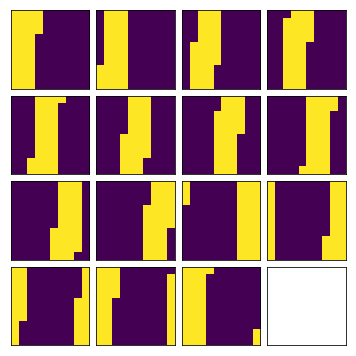

Execution time: at iteration 0 is 6.947111368179321 seconds


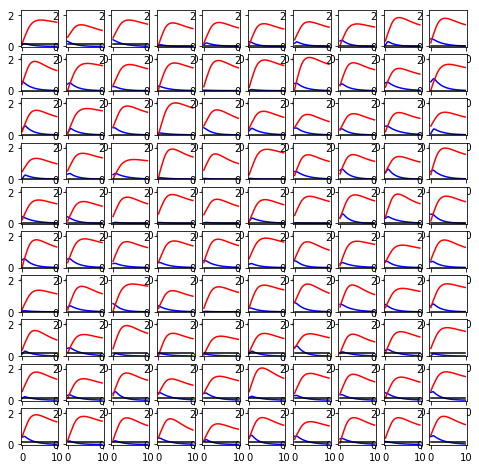

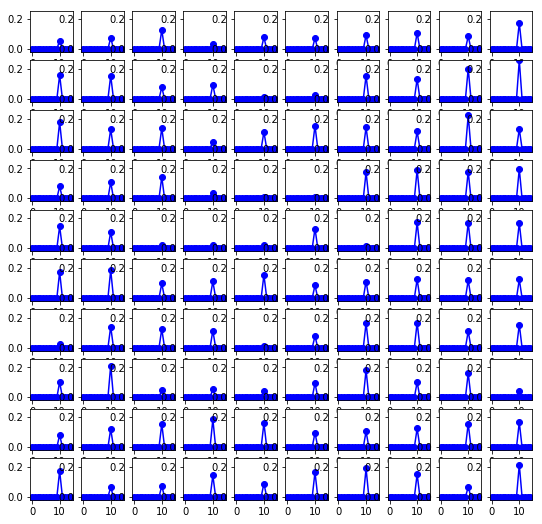

Presentation 1
Execution time: at iteration 1 is 7.024047374725342 seconds
Execution time: at iteration 2 is 6.853612422943115 seconds
Execution time: at iteration 3 is 6.827007055282593 seconds
Execution time: at iteration 4 is 6.81946873664856 seconds
Execution time: at iteration 5 is 6.798214435577393 seconds
Execution time: at iteration 6 is 6.805609941482544 seconds
Execution time: at iteration 7 is 6.828883647918701 seconds
Execution time: at iteration 8 is 6.780045509338379 seconds
Execution time: at iteration 9 is 6.756671905517578 seconds
Execution time: at iteration 10 is 6.775995969772339 seconds
Execution time: at iteration 11 is 6.753445625305176 seconds
Execution time: at iteration 12 is 6.750933885574341 seconds
Execution time: at iteration 13 is 6.851926326751709 seconds
Execution time: at iteration 14 is 6.874841213226318 seconds


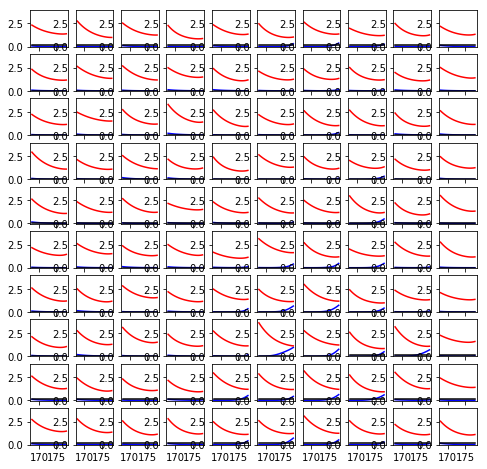

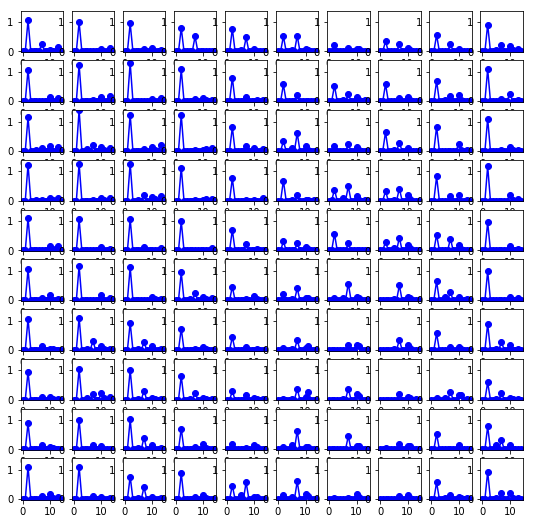

Presentation 15
Execution time: at iteration 15 is 6.951620817184448 seconds
Execution time: at iteration 16 is 6.755223751068115 seconds
Execution time: at iteration 17 is 6.766786336898804 seconds
Execution time: at iteration 18 is 6.755370378494263 seconds
Execution time: at iteration 19 is 6.759565114974976 seconds
Execution time: at iteration 20 is 6.801877975463867 seconds
Execution time: at iteration 21 is 6.729804039001465 seconds
Execution time: at iteration 22 is 6.752211093902588 seconds
Execution time: at iteration 23 is 6.758141279220581 seconds
Execution time: at iteration 24 is 6.7723166942596436 seconds
Execution time: at iteration 25 is 6.756091356277466 seconds
Execution time: at iteration 26 is 6.769583225250244 seconds
Execution time: at iteration 27 is 6.801616191864014 seconds
Execution time: at iteration 28 is 6.7297375202178955 seconds
Execution time: at iteration 29 is 6.817723512649536 seconds


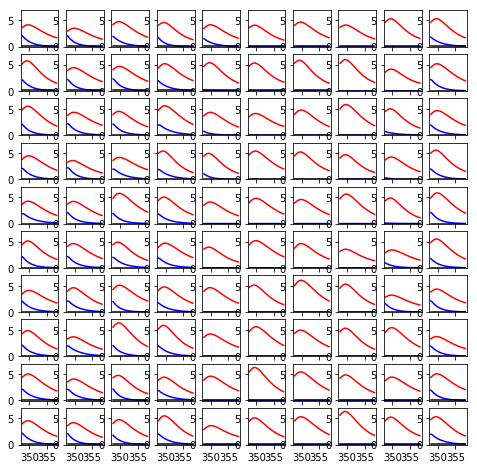

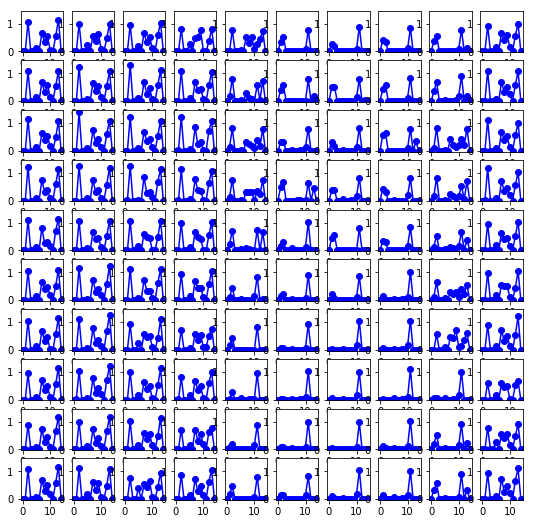

Presentation 30
Thu Sep 13 09:50:41 2018    restats

         431975714 function calls (429739458 primitive calls) in 239.875 seconds

   Ordered by: cumulative time
   List reduced from 1284 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000  239.876  239.876 {built-in method builtins.exec}
        1    0.000    0.000  239.876  239.876 <string>:1(<module>)
        1    0.089    0.089  239.876  239.876 <ipython-input-3-c439b55d6bd7>:234(run)
       60    0.421    0.007  197.656    3.294 /home/z/projects/draculab/network.py:676(run)
   360000    9.354    0.000  194.329    0.001 /home/z/projects/draculab/units.py:215(update)
   360000    2.173    0.000  135.886    0.000 {cython_utils.euler_int}
  1800000    1.303    0.000  133.713    0.000 /home/z/projects/draculab/units.py:2404(derivatives)
  1800000    2.646    0.000  127.681    0.000 /home/z/projects/draculab/units.py:139(get_input_sum)
  1800000   53.187 

In [4]:
""" Running a simulation. """
# create a parameters object with the default values
p = parameters()
# Set any values specific to this simulation
p.N = 10 # number of units
p.md = 0.2 # minimum delay in the connections
p.t_pat = 10. # time a pattern is presented
p.t_trans = 2. # transition time between patterns
p.PE_lrate = 1./250. #learning rate of PE connections
p.PI_lrate = 1./250.
p.IE_mask = {'circular':{'radius':1.9}}
p.IE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 2.}}
p.EI_mask = {'annular':{'inner_radius' : 1.5, 'outer_radius':2.7}}
p.EI_kernel = {'linear' : {'c' : 1.1, 'a' : 0.2}}
p.EE_mask = {'circular':{'radius':2.1}}
p.EE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 1.5}}
p.EI_weights = {'uniform' : {'low' : 0.06, 'high' : 0.2}}
p.pat_type = 'snake'
# Initialize a simulation object with the specific parameters
sel = selection(p) 
# Create all the draculab objects and the input patterns
sel.build()
# Show the input patterns
sel.display_inputs()
# Run the simulation
n_pres = 30 # number of input patterns to present
n_disp = 2  # number of times outputs will be displayed

#sel.run(n_pres, n_disp)

# profiling run
import cProfile
import pstats

cProfile.run('sel.run(n_pres, n_disp)', 'restats')
prof = pstats.Stats('restats')
prof.sort_stats('cumulative').print_stats(30)
# 280.896 seconds


In [10]:
sel.net.units[0].zippo[0]

TypeError: 'zip' object is not subscriptable

## Interesting parameter changes
With:

`p.N = 8 # number of units
p.md = 0.2 # minimum delay in the connections
p.t_pat = 10. # time a pattern is presented
p.t_trans = 2. # transition time between patterns
p.PE_lrate = 1./250. #learning rate of PE connections
p.PI_lrate = 1./250.`
You can get, if
* `p.pat_type = 'lines'`, pretty decent selectivity that can be observed in the weight grid.
* `p.pat_type = 'snake'`, a rather homogeneous response with giant inhibitions up to presentation 80.
* `p.pat_type = 'random'`, responses become very homogeneous in here too.

Homogeneity may dissapear when lateral competition is dominant. Say:

`p.N = 10 # number of units
p.md = 0.2 # minimum delay in the connections
p.t_pat = 10. # time a pattern is presented
p.t_trans = 2. # transition time between patterns
p.PE_lrate = 1./250. #learning rate of PE connections
p.PI_lrate = 1./250.
p.IE_mask = {'circular':{'radius':1.9}}
p.IE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 2.}}
p.EI_mask = {'annular':{'inner_radius' : 1.5, 'outer_radius':2.7}}
p.EI_kernel = {'linear' : {'c' : 1.1, 'a' : 0.2}}
p.EE_mask = {'circular':{'radius':2.1}}
p.EE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 1.5}}
p.EI_weights = {'uniform' : {'low' : 0.06, 'high' : 0.2}}
p.pat_type = 'snake'`

With this the units break down into two groups. Units in the same group have a similar response profile. Changing `p.N = 12` creates 3 groups instead of two. It seems the number of groups is related to the diameter of the Mexican hat in relation to the network.
To test this, I set `p.pat_type = 'random'`, and manually changed the code in selection.build() so only 3 different input patterns would be generated. Along 100 pattern presentations there were points where the population seemed to be dividing into 3 groups, each preferring one of the 3 patterns. At the end, however, 

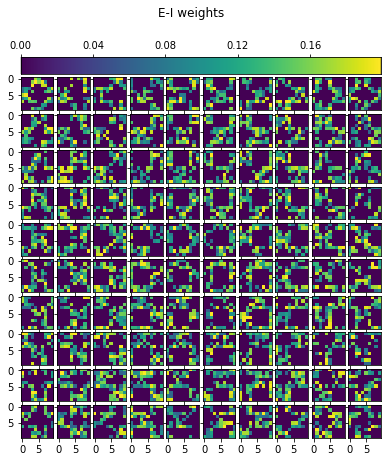

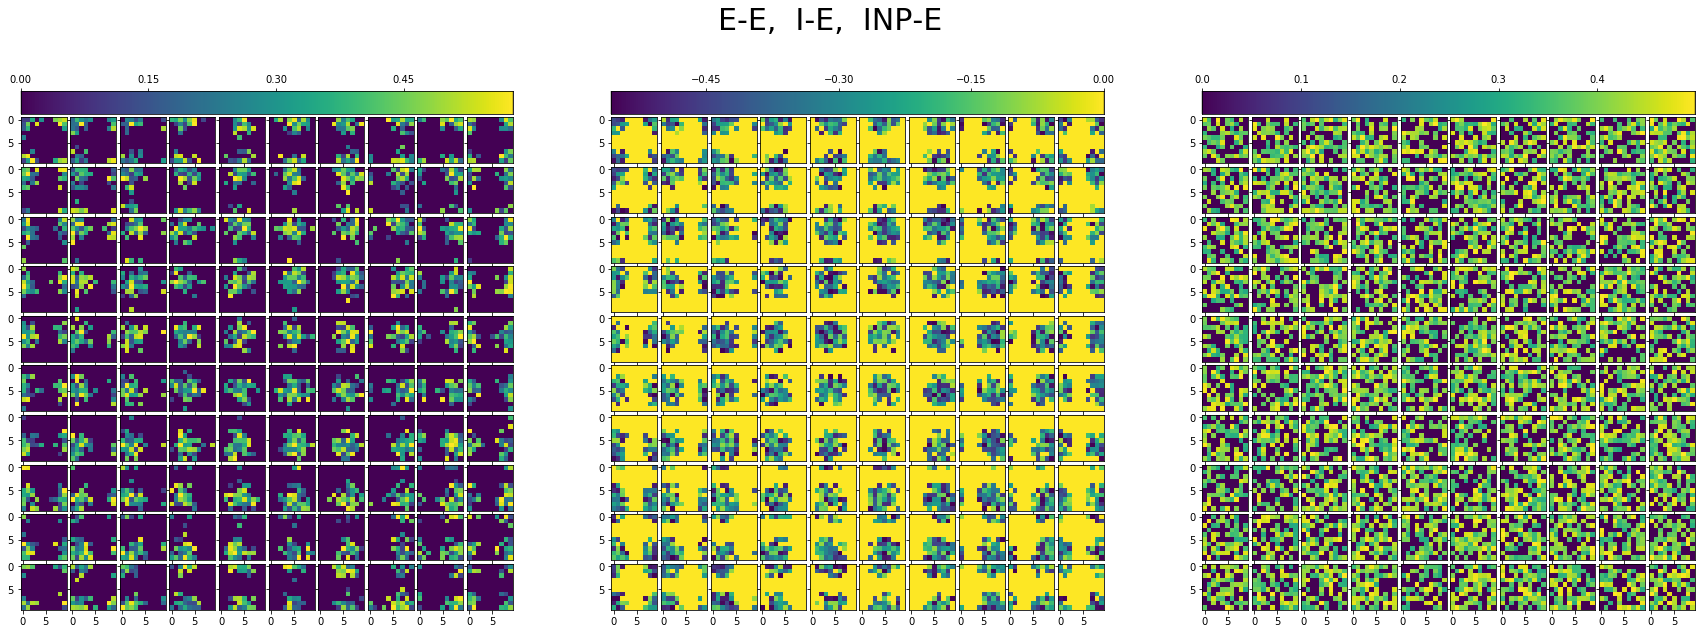

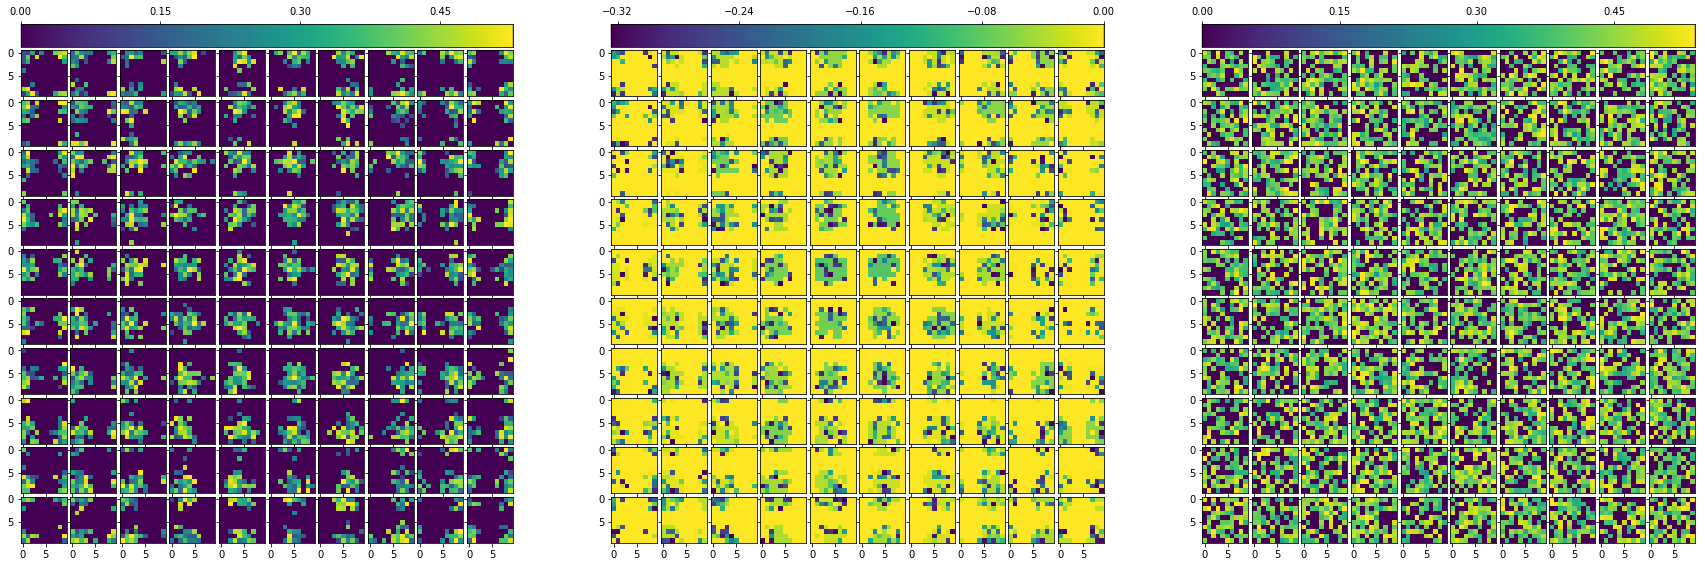

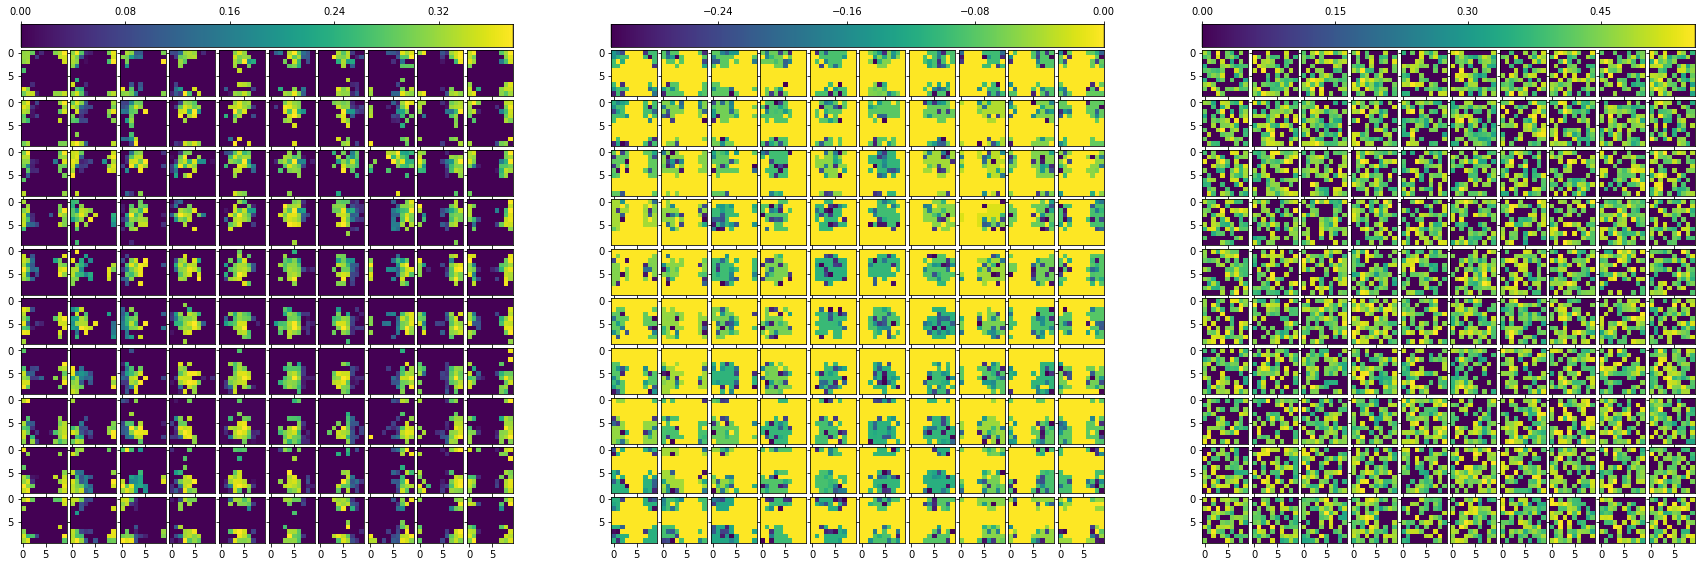

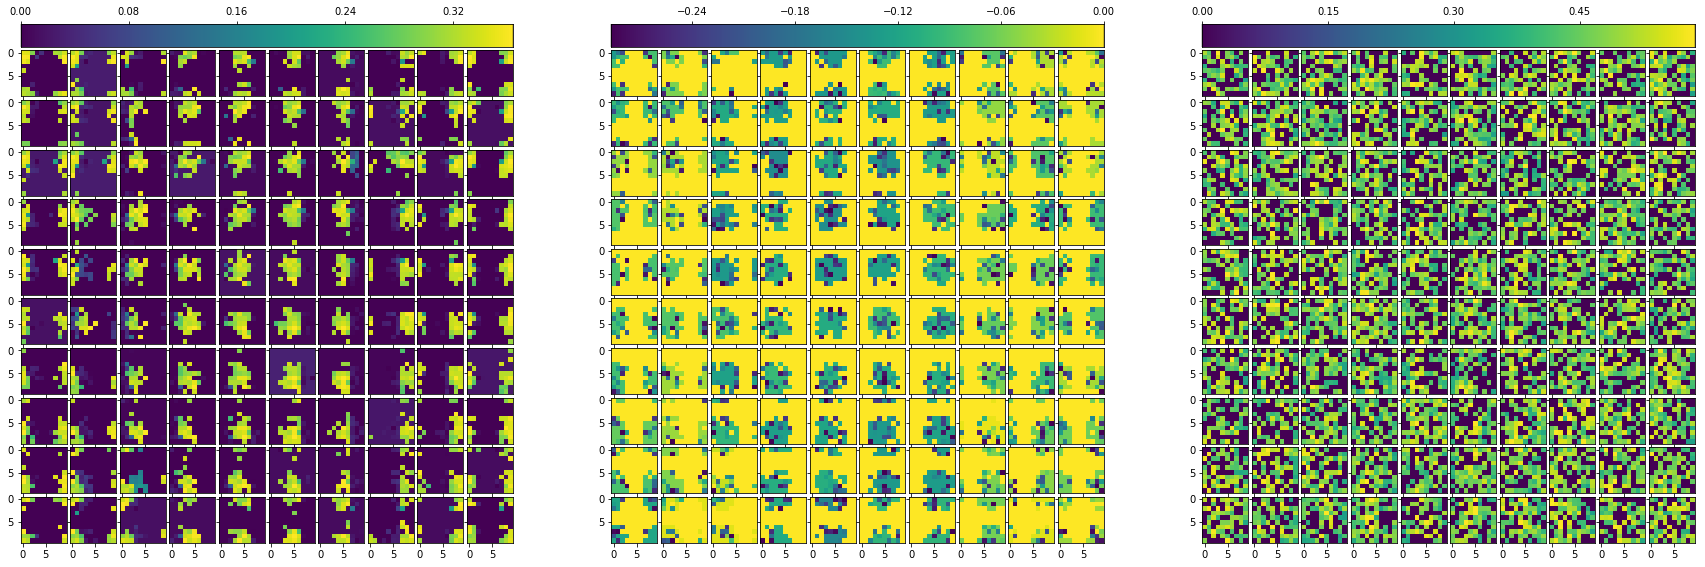

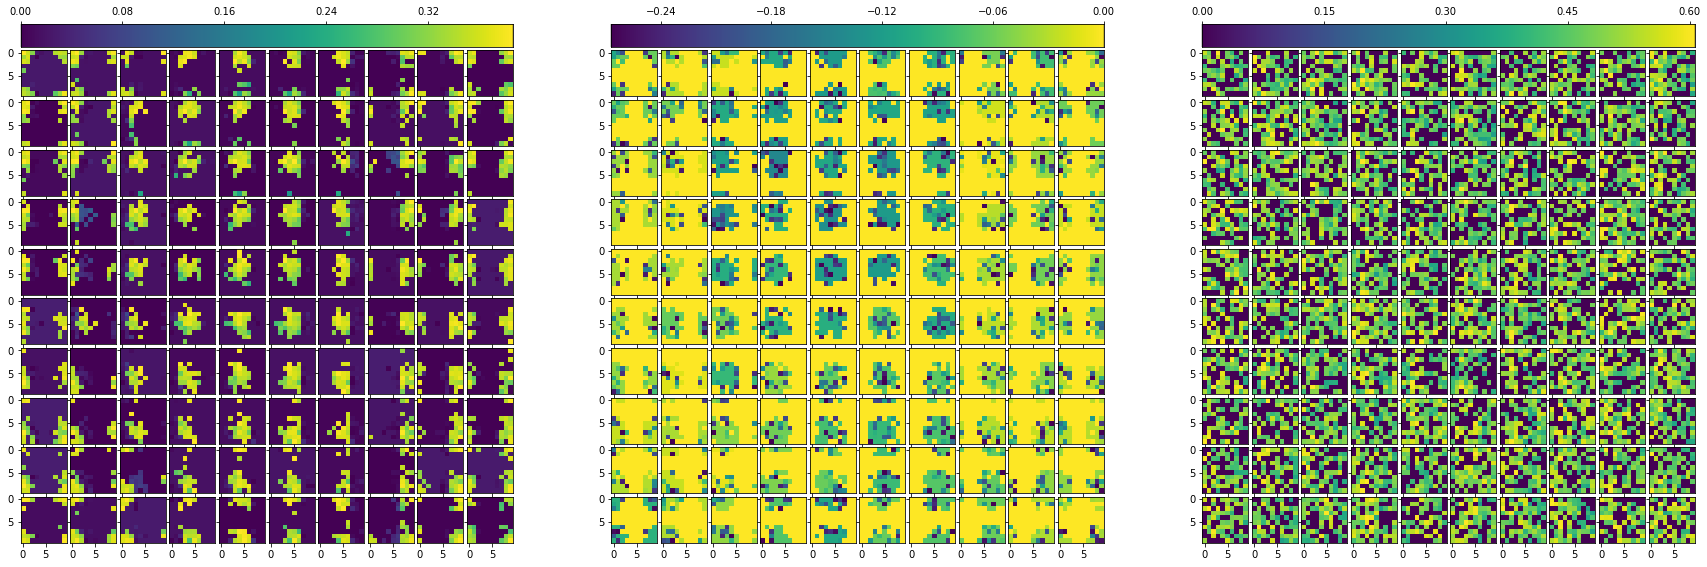

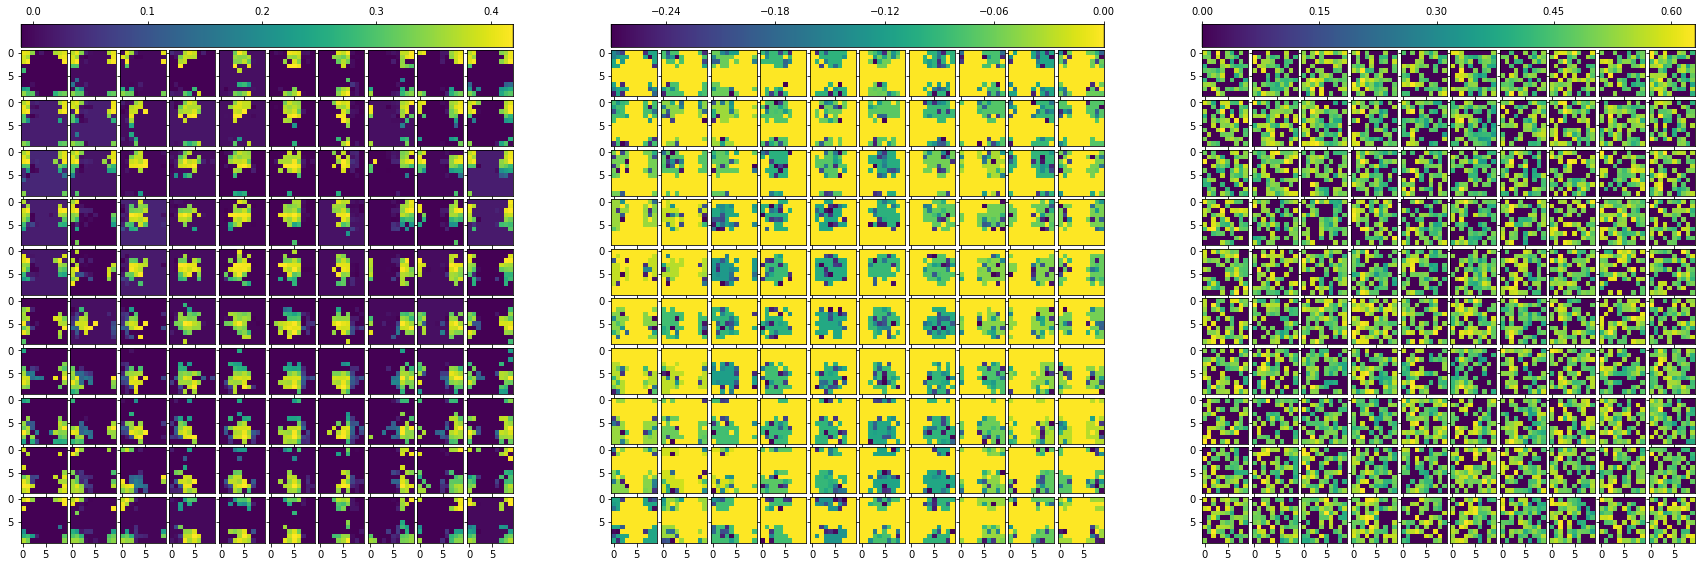

Excitatory squared sums:	[3.8861780653139237, 3.8465573854878063, 2.5247470279908493, 2.4999771702623472, 2.4981230398541872, 2.4982644717930094]
Inhibitory sums:	[-12.280549643642452, -2.5623704413033543, -3.8960242742849505, -3.7110287516380671, -3.066375495097807, -5.2299921063802222]
External input sums: 	[22.041620881345981, 23.130067138688453, 25.05212055714507, 26.147551070697755, 27.447100872981537, 28.650587348966653]


In [5]:
sel.view_weight_grid()

<IPython.core.display.Javascript object>


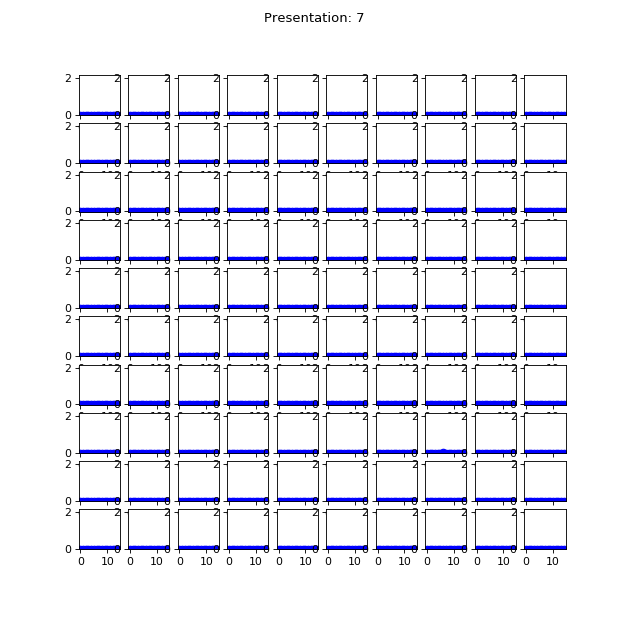

In [8]:
from matplotlib.animation import FuncAnimation
#%matplotlib notebook
%matplotlib qt5
ani = sel.animate_responses(50)
#plt.show()

Execution time: at iteration 0 is 8.043429136276245 seconds


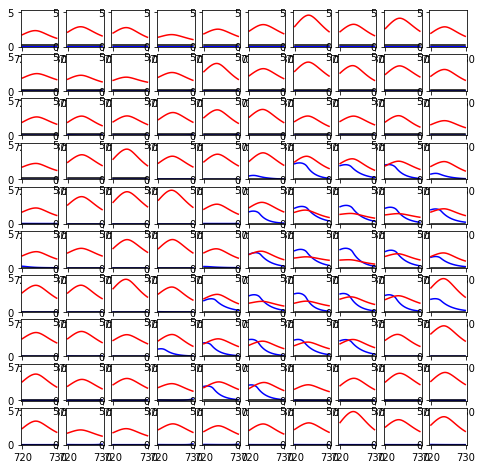

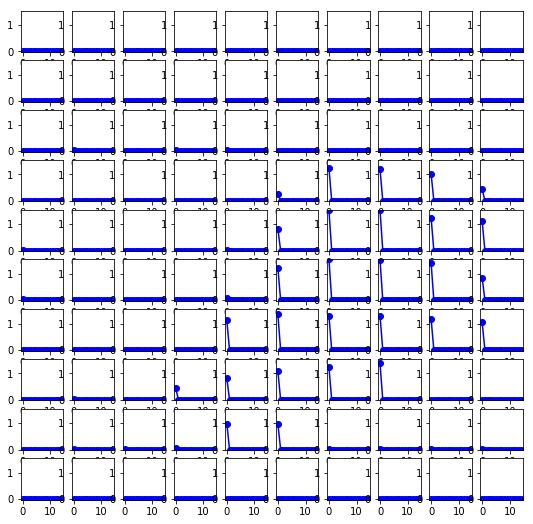

Presentation 1
Execution time: at iteration 1 is 8.056318759918213 seconds
Execution time: at iteration 2 is 7.914753198623657 seconds
Execution time: at iteration 3 is 7.90579080581665 seconds
Execution time: at iteration 4 is 8.233118534088135 seconds
Execution time: at iteration 5 is 7.97826361656189 seconds
Execution time: at iteration 6 is 7.9246134757995605 seconds
Execution time: at iteration 7 is 8.1322021484375 seconds
Execution time: at iteration 8 is 7.954434871673584 seconds
Execution time: at iteration 9 is 7.86337947845459 seconds
Execution time: at iteration 10 is 8.322763681411743 seconds
Execution time: at iteration 11 is 8.138489484786987 seconds
Execution time: at iteration 12 is 7.900775194168091 seconds
Execution time: at iteration 13 is 8.091675996780396 seconds
Execution time: at iteration 14 is 8.199953317642212 seconds
Execution time: at iteration 15 is 7.863433599472046 seconds
Execution time: at iteration 16 is 8.419836044311523 seconds
Execution time: at ite

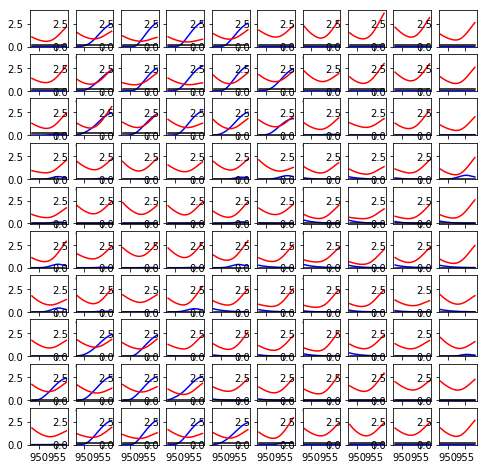

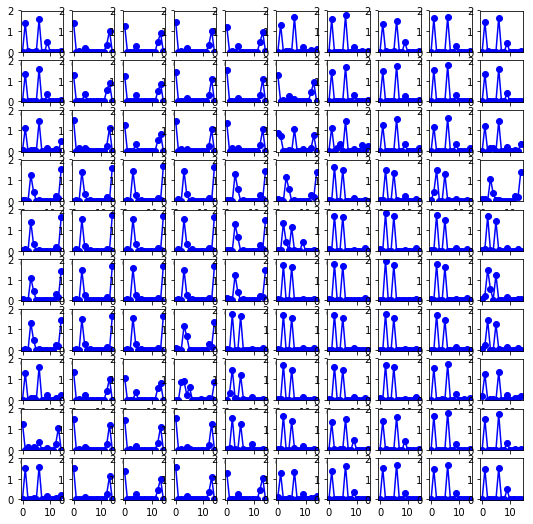

Presentation 20
Execution time: at iteration 20 is 8.200409889221191 seconds
Execution time: at iteration 21 is 8.21030306816101 seconds
Execution time: at iteration 22 is 8.581881046295166 seconds
Execution time: at iteration 23 is 8.276987075805664 seconds
Execution time: at iteration 24 is 8.654115200042725 seconds
Execution time: at iteration 25 is 8.662931442260742 seconds
Execution time: at iteration 26 is 8.530964851379395 seconds
Execution time: at iteration 27 is 9.226472616195679 seconds
Execution time: at iteration 28 is 7.958832263946533 seconds
Execution time: at iteration 29 is 9.285593271255493 seconds
Execution time: at iteration 30 is 8.718335628509521 seconds
Execution time: at iteration 31 is 8.773857831954956 seconds
Execution time: at iteration 32 is 8.871247291564941 seconds
Execution time: at iteration 33 is 8.30839490890503 seconds
Execution time: at iteration 34 is 8.975102424621582 seconds
Execution time: at iteration 35 is 8.782536745071411 seconds
Execution 

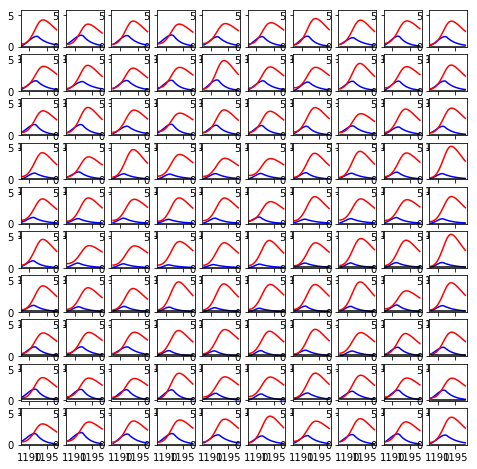

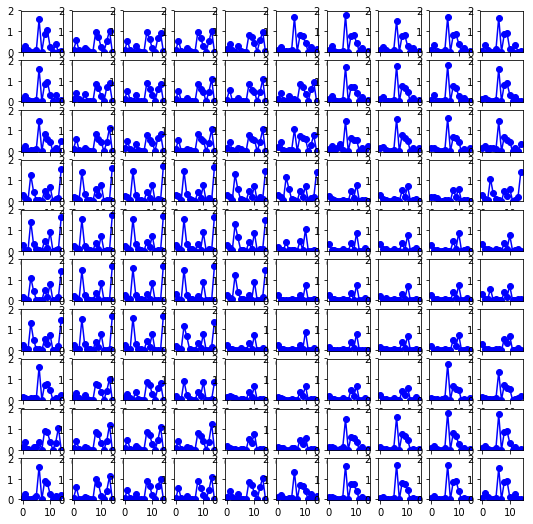

Presentation 40


In [8]:
""" Want to continue? """
# Run the simulation
n_pres = 40 # number of inputpatterns to present
n_disp = 2  # number of times outputs will be displayed
sel.run(n_pres, n_disp)

The point of these simulations is to find whether the E-I network with the type of plasticity from Moldakarinov06 is suited for becoming a network where each unit selects a particular subset of the descending inputs.

Due to the topological arrangement of the connections, it is reasonable to assume that spatially structured inputs, such as the "progressive lines" will have patterns that target some units slightly more than others. The point is for the network to pick on those slight preferences and to enhance them using the lateral connections as exta constraints.

In the case of the progressive lines we can: 
* find a 'center' for each pattern, as the average of the coordinates for each unit that is on when the pattern is present. That's the 'centers' vector obtained above.
* for each excitatory unit, measure its average activity level for each pattern. 
* plot what is the correlation between the distance to a pattern VS the activity level when the pattern is presented.
  This can be done in first vs last iterations.

This figure shows that units become very selective to particular patterns, and the number of units devoted to each pattern is evenly distributed. It is not quite how I imagined it, but it couldn't be better.

In [9]:
p = np.array([[1,2],[3,4]])
print(p.shape)
p.reshape(4,order='F')

(2, 2)


array([1, 3, 2, 4])